# Sessa Empirical Estimator (SEE)
An algorithm used to compute the duration of pharmacological prescriptions when information on the prescribed dose and daily consumption is missing or incomplete. This minimizes using rules or assumptions that are commonly used to automate the process of computing prescriptions' duration.

# Libraries used

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF
import adherer as ad
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import adherer as ad

# Dataset
The dataset used was an artifical dataset from AdhereR's `med.events`, containing medication events (one per row) for 100 patients (1080 events in total). 

In [233]:
# Load the dataset
tidy = pd.read_csv('med-events.csv', sep='\t', header=0)

tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy["eksd"] = pd.to_datetime(tidy["eksd"], format="%m/%d/%Y")
tidy["eksd"] = tidy["eksd"].dt.strftime("%m/%d/%Y")
tidy

,pnr,eksd,perday,ATC,dur_original
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30
...,...,...,...,...,...
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30


## Adherence of patients with their treatment
Patients are divided into 6 adherence groups namely:
1) high  
2) medium 
3) non-persistence 
4) intermittent (with a change between high and low adherence at regular intervals), 
5) Partial drop-off (with high adherence initially and partial drop-off after some time), 
6) non-persistence

Loading required package: AdhereR


OK: the results were exported successfully (but there might be warnings and messages above worth paying attention to)!
Adherer returned code 0 and said:
AdhereR 0.8.1 on R 4.4.2 started at 2025-02-25 17:14:18.693454:
OK: the results were exported successfully (but there might be warnings and messages above worth paying attention to)!



,pnr,CMA,Category
0,1,0.947945,Gradually Declining
1,2,0.616438,Medium
2,3,0.994521,High
3,4,0.379452,Non-Persistence
4,5,0.369863,Non-Persistence
...,...,...,...
95,96,0.935616,Gradually Declining
96,97,0.636986,Medium
97,98,0.479452,Non-Persistence
98,99,0.287671,Non-Persistence


,Category,Count
0,Non-Persistence,41
1,Medium,37
2,High,12
3,Gradually Declining,10


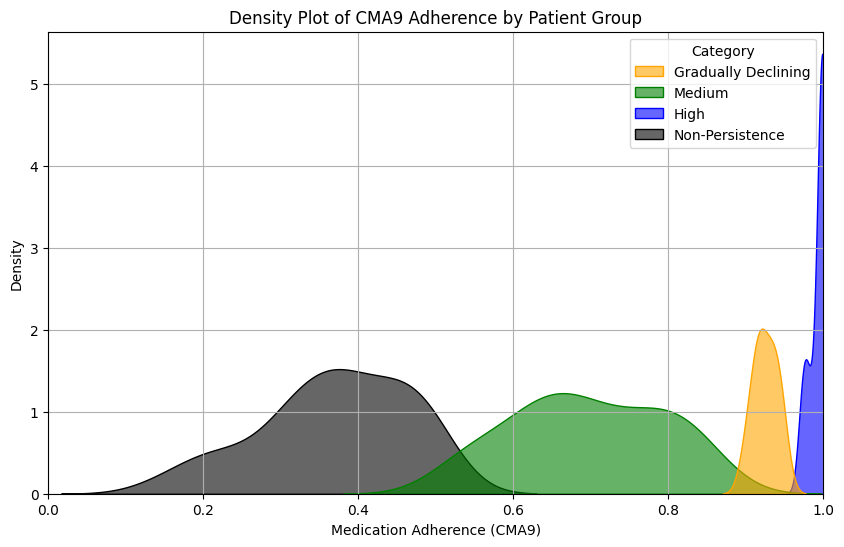

In [251]:
cma9 = ad.CMA9(
    tidy,
    id_colname='pnr',
    event_date_colname='eksd',
    event_duration_colname='dur_original',
    event_daily_dose_colname='perday',
    medication_class_colname='ATC',
    observation_window_start=0,  # Default is 0, but you can change it
    observation_window_duration=730 # Set to 365 days (or any desired value)
)

cma9.get_computation_results()
patientAdherence = cma9.get_cma()
#display(patientAdherence)

# Assuming patientAdherence has columns: ['PATIENT_ID', 'CMA']
patientAdherenceCopy = patientAdherence.copy()

# Function to categorize patients
def classify_adherence(cma_series):
    """Classifies a patient based on their CMA9 adherence pattern."""
    mean_cma = cma_series.mean()
    std_cma = cma_series.std()
    
    if mean_cma >= 0.95:
        return "High"
    elif 0.50 <= mean_cma < 0.90:
        return "Medium"
    elif mean_cma < 0.50:
        return "Non-Persistence"
    elif cma_series.is_monotonic_decreasing:  # Gradual decline
        return "Gradually Declining"
    elif std_cma > 0.25:  # High variability suggests intermittent
        return "Intermittent"
    elif mean_cma >= 0.90 and cma_series.iloc[-1] < 0.50:  # Drops after high adherence
        return "Partial Drop-Off"
    else:
        return "Unclassified"

# Group patients by adherence patterns
patientAdherenceCopy['Category'] = patientAdherenceCopy.groupby('pnr')['CMA'].transform(classify_adherence)

# Remove unclassified patients
patientAdherenceCopy = patientAdherenceCopy[patientAdherenceCopy['Category'] != "Unclassified"]

# Assign colors to categories
palette = {
    "High": "blue",
    "Medium": "green",
    "Gradually Declining": "orange",
    "Intermittent": "purple",
    "Partial Drop-Off": "red",
    "Non-Persistence": "black"
}

display(patientAdherenceCopy[['pnr', 'CMA', 'Category']])  # Check if Category column is assigned
category_counts = patientAdherenceCopy['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

display(category_counts)  # Show as DataFrame



# Plot density for each category
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=patientAdherenceCopy, x="CMA", hue="Category", fill=True, palette=palette, alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
if labels:  # If labels exist, add a legend
    plt.legend(handles, labels, title="Adherence Category")
plt.xlabel("Medication Adherence (CMA9)")
plt.ylabel("Density")
plt.title("Density Plot of CMA9 Adherence by Patient Group")
plt.xlim(0, 1)
plt.grid(True)

# Show plot
plt.show()




# The algorithm (Using K-means clustering)

Function `rmv_uppr_20` returns the first 80% of prescription records in the empirical cumulative distribution of event intervals

### Step 1. 
For each studied patient, SEE randomly selects a pair of consecutive filled prescriptions within the study period. 

Randomly selecting a prescription record per patient from the dataset.

Function `slct_prscrption_per_patient` returns the randomly selected prescription per patient.

In [221]:
def slct_prscrption_per_patient(data):
    prscrption_per_patient = data.groupby("pnr").sample(n=1, random_state=1234)
    return prscrption_per_patient
    
# step2Data = slct_prscrption_per_patient(step1Data)

### Step 2. 
For all patients from the outputted data in the previous step, SEE computes the Empirical Cumulative Distribution Functions (ECDF) of the time gaps (or temporal distances) between the filling of prescriptions (within the study period).The upper 20% of the ECDF is ecxluded.

In [222]:
def rmv_uppr_20(data):
    data_ecdf = data.copy()
    
    # ECDF computation
    ecdf = ECDF(data_ecdf["event_interval"])
    dfper = pd.DataFrame({"x": ecdf.x, "y": ecdf.y})
    
    # Retain first 80% of ECDF
    dfper = dfper[dfper["y"] <= 0.8]

    # print("dfper")
    # print(dfper)
    
    # Determine max event interval within the 80% threshold
    ni = dfper["x"].max()
    # print("ni")
    # print(ni)
    
    # Filter patients with event intervals within this range
    lower_80 = data.copy()
    lower_80 = lower_80[(lower_80["event_interval"] > 0) & (lower_80["event_interval"] <= ni)]

    return lower_80, dfper

# step1Data = rmv_uppr_20("medB")
    

### Step 3. 
The temporal distances (time gaps) of the randomly selected filled prescriptions from the previous step are logged, undergo KDE estimation, and then standardized.


Function `stndrdize_event_intervals` returns the standardized data to be clustered in the next step.

In [223]:
def stndrdize_event_intervals(data):
    # log_event_intervals = np.log(data["event_interval"])
    # scaler = StandardScaler()
    # standardized_intervals = scaler.fit_transform(log_event_intervals.values.reshape(-1, 1))
    
    # # Convert back to a DataFrame (optional)
    # data["standardized_event_interval"] = standardized_intervals.flatten()    

    # logged_event_intervals = np.log(data["event_interval"])
    # print("Natural logged event intervals")
    # print(logged_event_intervals)

    # print("infs or NaNs in logged_event_intervals")
    # invalid_mask = np.isnan(logged_event_intervals) | np.isinf(logged_event_intervals)
    # print(logged_event_intervals[invalid_mask])

    # KDE estimation on log-transformed event intervals
    density = gaussian_kde(np.log(data["event_interval"]))
    x_vals = np.linspace(min(np.log(data["event_interval"])), max(np.log(data["event_interval"])), 1000)
    y_vals = density(x_vals)

    # Standardize data for clustering
    a = np.column_stack((x_vals, y_vals))
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    return a_scaled
    
# step3Data = stndrdize_event_intervals(step2Data)
# step3Data

### Step 4.
The K-means algorithm will cluster the temporal distances (time gaps) into K groups (minimizing the sum of squares from the temporal distances to the assigned cluster centers). The optimal number of clusters is selected using Silhouette analysis and K-means will be performed again. Afterwards compute the median for each cluster.

In [224]:
def k_means_clustering(data, dfper):
    # Find optimal clusters using silhouette method
    silhouette_scores = []
    cluster_range = range(2, 10)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    # Determine best cluster number
    max_cluster = cluster_range[np.argmax(silhouette_scores)]
    print(f"max_cluster:{max_cluster}" )

    # Check for infinite or NaN values in dfper["x"]
    if np.any(np.isinf(dfper["x"])) or np.any(np.isnan(dfper["x"])):
        print("Warning: Infinite or NaN values found in dfper['x']. Removing them.")
        dfper = dfper.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
        dfper = dfper.dropna(subset=["x"])  # Drop rows with NaN values
    
    # Ensure there is still data left after cleaning
    if len(dfper) == 0:
        raise ValueError("No valid data left for clustering after removing infinite/NaN values.")

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)
    dfper["cluster"] = kmeans.fit_predict(dfper[["x"]])

    cluster_stats = dfper.groupby("cluster")["x"].agg(["min", "max", "median"]).reset_index()

    return cluster_stats, dfper

# step4Data = k_means_clustering(step3Data)

### Step 5.
Cluster assignment

In [225]:
def cluster_assignment(data, original_data, cluster_stats):
    # Assign cluster based on event interval
    results = data.merge(cluster_stats, how="cross")
    results["Final_cluster"] = np.where(
        (results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"]),
        results["cluster"],
        np.nan
    )
    
    # Drop rows with no assigned cluster
    results.dropna(subset=["Final_cluster"], inplace=True)
    
    # Merge with original data
    #Drug_see_p1 is step2Data
    data = data.merge(results[["pnr", "median", "Final_cluster"]], on="pnr", how="left")
    
    # Fill missing values with most frequent cluster median
    most_common_cluster = results["Final_cluster"].mode()[0]
    most_common_median = results[results["Final_cluster"] == most_common_cluster]["median"].median()
    data["median"].fillna(most_common_median, inplace=True)
    
    # Assign median duration to original dataset
    original_data_clusterAssigned = original_data.merge(data[["pnr", "median"]], on="pnr", how="left")
    
    return original_data_clusterAssigned


## SEE code

In [226]:
def SEE(arg1):
    C09CA01 = tidy[tidy["ATC"] == arg1].copy() # Filter data for the given medicine
    C09CA01["eksd"] = pd.to_datetime(C09CA01["eksd"], format="%m/%d/%Y") # Ensure the 'eksd' column is converted to datetime format
    C09CA01.sort_values(by=["pnr", "eksd"], inplace=True) # Sort by patient ID and prescription date
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1) # Compute previous prescription date
    C09CA01.dropna(subset=["prev_eksd"], inplace=True) # Drop rows where previous date is missing
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days # Compute event interval (days between prescriptions)

    rndm_prscrption_per_patient = slct_prscrption_per_patient(C09CA01) # step 1
    
    lower_80, dfper = rmv_uppr_20(rndm_prscrption_per_patient) # step 2
        
    event_intervals_stndrdized = stndrdize_event_intervals(lower_80) # step 3
    
    cluster_stats, dfper = k_means_clustering(event_intervals_stndrdized, dfper) # step 4
    print(f"{arg1} cluster stats:")
    display(cluster_stats)
    
    original_data_clusterAssigned = cluster_assignment(rndm_prscrption_per_patient, C09CA01, cluster_stats) # step 5

    return original_data_clusterAssigned
    

In [227]:
def see_assumption(data):
    data = data.sort_values(by=["pnr", "eksd"])
    
    # Compute previous prescription date and event interval
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    data.dropna(subset=["prev_eksd"], inplace=True)
    data["Duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    
    # Count prescription number per patient
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    # Boxplot of duration grouped by prescription number
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data["p_number"], y=data["Duration"])
    plt.axhline(y=data["Duration"].median(), color="red", linestyle="dashed")
    plt.title("Prescription Count vs Duration")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (Days)")
    plt.show()



## MedA information

max_cluster:2
medA cluster stats:


,cluster,min,max,median
0,0,7.0,84.0,44.0
1,1,92.0,157.0,133.5


/tmp/ipykernel_324903/892312685.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["median"].fillna(most_common_median, inplace=True)


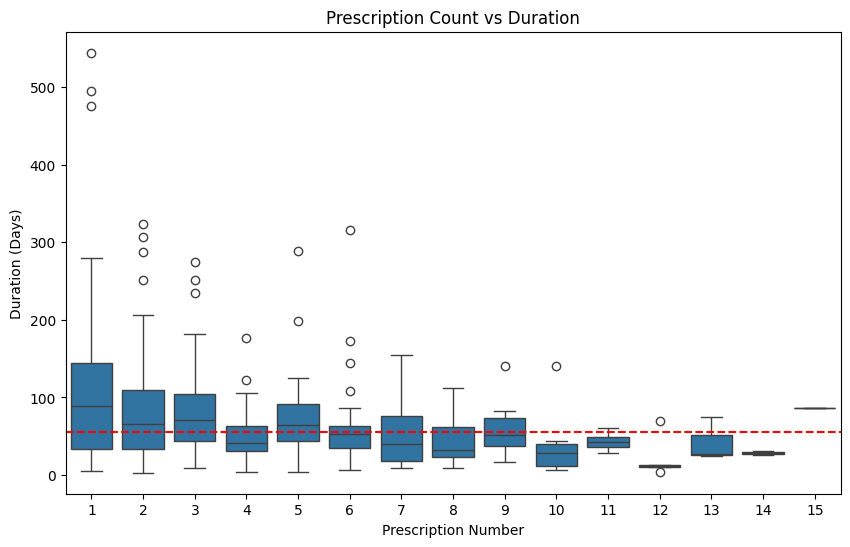

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval,median
0,2,2036-03-10,4,medA,50,2036-01-20,50,44.0
1,2,2036-08-01,4,medA,50,2036-03-10,144,44.0
2,4,2032-11-27,4,medA,50,2032-05-01,210,44.0
3,4,2033-08-20,4,medA,50,2032-11-27,266,44.0
4,4,2033-08-30,4,medA,50,2033-08-20,10,44.0
...,...,...,...,...,...,...,...,...
444,98,2034-02-25,4,medA,50,2034-01-02,54,133.5
445,98,2034-12-10,4,medA,50,2034-02-25,288,133.5
446,99,2032-06-16,4,medA,50,2031-11-08,221,133.5
447,99,2032-09-18,4,medA,50,2032-06-16,94,133.5


In [228]:
medA = SEE("medA")
see_assumption(medA)
medA


## MedB information

max_cluster:2
medB cluster stats:


,cluster,min,max,median
0,0,0.0,37.0,23.0
1,1,40.0,79.0,53.0


/tmp/ipykernel_324903/892312685.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["median"].fillna(most_common_median, inplace=True)


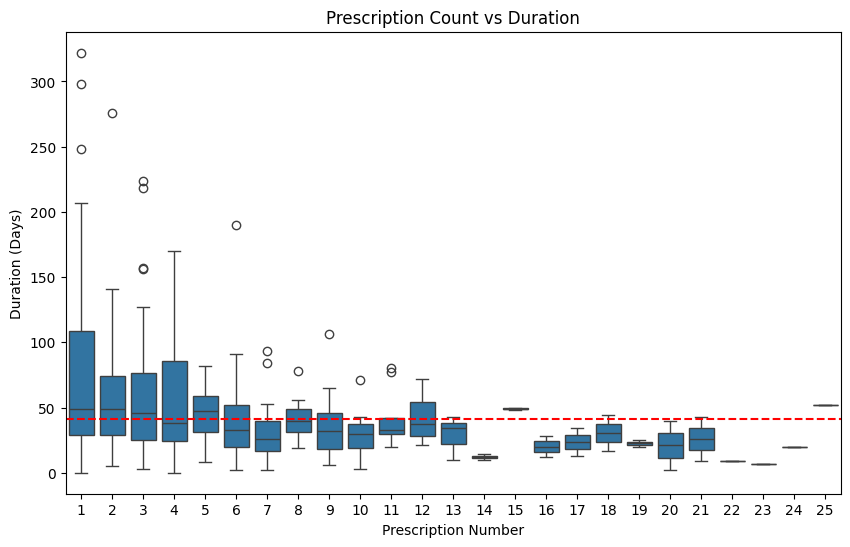

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval,median
0,1,2033-08-03,4,medB,30,2033-07-04,30,23.0
1,1,2033-08-17,4,medB,30,2033-08-03,14,23.0
2,1,2033-10-13,4,medB,30,2033-08-17,57,23.0
3,1,2033-10-16,4,medB,30,2033-10-13,3,23.0
4,1,2033-11-23,4,medB,30,2033-10-16,38,23.0
...,...,...,...,...,...,...,...,...
426,100,2034-03-05,6,medB,30,2034-01-22,42,53.0
427,100,2034-04-07,6,medB,30,2034-03-05,33,53.0
428,100,2034-04-26,6,medB,30,2034-04-07,19,53.0
429,100,2034-05-26,6,medB,30,2034-04-26,30,53.0


In [229]:
medB = SEE("medB")
see_assumption(medB)
medB
